# Cell 1: 노트북 개요

## 03_kitti_exploration.ipynb - KITTI 데이터 탐색

이 노트북에서는 KITTI 데이터셋을 탐색하고 Self-supervised 사전학습을 위한 데이터를 준비합니다.

### 목표
1. KITTI 디렉토리 구조 확인
2. 이미지 시퀀스 로드 및 시각화
3. 연속 프레임 분석
4. Self-supervised 학습용 데이터셋 구성
5. Train/Val 분할

### 참고 논문
- **KITTI Vision Benchmark** (Geiger et al., CVPR 2012): 자율주행 벤치마크 데이터셋
- **SimCLR** (Chen et al., ICML 2020): Contrastive learning을 위한 연속 프레임 활용

In [1]:
# Cell 1: 라이브러리 및 설정

import sys
import os
import glob
import logging
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 프로젝트 루트
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# KITTI 데이터 경로
DATASET_ROOT = PROJECT_ROOT / 'dataset'
KITTI_PATHS = {
    'kitti_tracking': DATASET_ROOT / 'kitti_tracking',
    # 'kitti_raw': DATASET_ROOT / 'kitti', # 필요시 추가
}

print(f"프로젝트 루트: {PROJECT_ROOT}")
print(f"데이터셋 루트: {DATASET_ROOT}")

프로젝트 루트: c:\git\automotive
데이터셋 루트: c:\git\automotive\dataset


In [2]:
# Cell 2: KITTI 디렉토리 구조 확인

def explore_directory(path, max_depth=3, current_depth=0):
    """디렉토리 구조 탐색"""
    if current_depth >= max_depth:
        return
    
    path = Path(path)
    if not path.exists():
        print(f"{'  ' * current_depth}❌ {path.name} (없음)")
        return
    
    indent = '  ' * current_depth
    
    if path.is_file():
        size_mb = path.stat().st_size / (1024 * 1024)
        print(f"{indent}📄 {path.name} ({size_mb:.1f} MB)")
    else:
        children = list(path.iterdir())
        print(f"{indent}📁 {path.name}/ ({len(children)} items)")
        
        # 하위 항목 (최대 5개)
        for child in children[:5]:
            explore_directory(child, max_depth, current_depth + 1)
        
        if len(children) > 5:
            print(f"{indent}  ... 그 외 {len(children) - 5}개")

print("=" * 50)
print("KITTI 데이터셋 구조 탐색")
print("=" * 50)

for name, path in KITTI_PATHS.items():
    print(f"\n[{name}]")
    explore_directory(path, max_depth=3)

KITTI 데이터셋 구조 탐색

[kitti_tracking]
📁 kitti_tracking/ (4 items)
  📁 data_tracking_calib/ (2 items)
    📁 testing/ (1 items)
    📁 training/ (1 items)
  📁 label/ (21 items)
    📄 0000.txt (0.1 MB)
    📄 0001.txt (0.6 MB)
    📄 0002.txt (0.3 MB)
    📄 0003.txt (0.1 MB)
    📄 0004.txt (0.3 MB)
    ... 그 외 16개
  📁 testing/ (1 items)
    📁 image_02/ (29 items)
      ... 그 외 24개
  📁 training/ (1 items)
    📁 image_02/ (21 items)
      ... 그 외 16개


In [3]:
# Cell 3: 이미지 시퀀스 찾기

from utils.data_utils import get_kitti_sequences

# 모든 시퀀스 찾기
all_sequences = []
for name, path in KITTI_PATHS.items():
    print(f"검색 경로: {path}")
    seqs = get_kitti_sequences(str(path))
    all_sequences.extend(seqs)
    print(f"{name}: {len(seqs)}개 시퀀스 발견")

# 중복 제거
all_sequences = sorted(list(set(all_sequences)))
print(f"\n총 {len(all_sequences)}개 고유 시퀀스 발견")

2025-12-14 07:04:49,212 - INFO - KITTI 시퀀스 50개 발견 (경로: c:\git\automotive\dataset\kitti_tracking)


검색 경로: c:\git\automotive\dataset\kitti_tracking
kitti_tracking: 50개 시퀀스 발견

총 50개 고유 시퀀스 발견


In [4]:
# Cell 4: 시퀀스 정보 분석

sequence_info = []

for seq_dir in tqdm(all_sequences, desc="시퀀스 분석"):
    # 이미지 파일 찾기
    seq_path = Path(seq_dir)
    images = sorted(list(seq_path.glob('*.png')) + list(seq_path.glob('*.jpg')))
    
    if len(images) == 0:
        continue
    
    # 샘플 이미지로 크기 확인
    sample_img = cv2.imread(str(images[0]))
    if sample_img is None:
        continue
    
    height, width = sample_img.shape[:2]
    
    sequence_info.append({
        'path': str(seq_dir),
        'num_images': len(images),
        'width': width,
        'height': height,
        'extension': images[0].suffix
    })

# DataFrame으로 변환
seq_df = pd.DataFrame(sequence_info)

if len(seq_df) > 0:
    print(f"\n총 시퀀스: {len(seq_df)}개")
    print(f"총 이미지: {seq_df['num_images'].sum():,}장")
    print(f"\n이미지 크기 분포:")
    print(seq_df.groupby(['width', 'height']).size())
    print(f"\n시퀀스 길이 통계:")
    print(seq_df['num_images'].describe())
else:
    print("이미지 시퀀스를 찾을 수 없습니다.")

시퀀스 분석:   0%|          | 0/50 [00:00<?, ?it/s]


총 시퀀스: 50개
총 이미지: 19,103장

이미지 크기 분포:
width  height
1224   370       14
1226   370        2
1238   374        2
1241   376        1
1242   375       31
dtype: int64

시퀀스 길이 통계:
count      50.000000
mean      382.060000
std       267.042029
min        78.000000
25%       175.250000
50%       309.500000
75%       444.250000
max      1176.000000
Name: num_images, dtype: float64


샘플 시퀀스: 0010
이미지 수: 1176


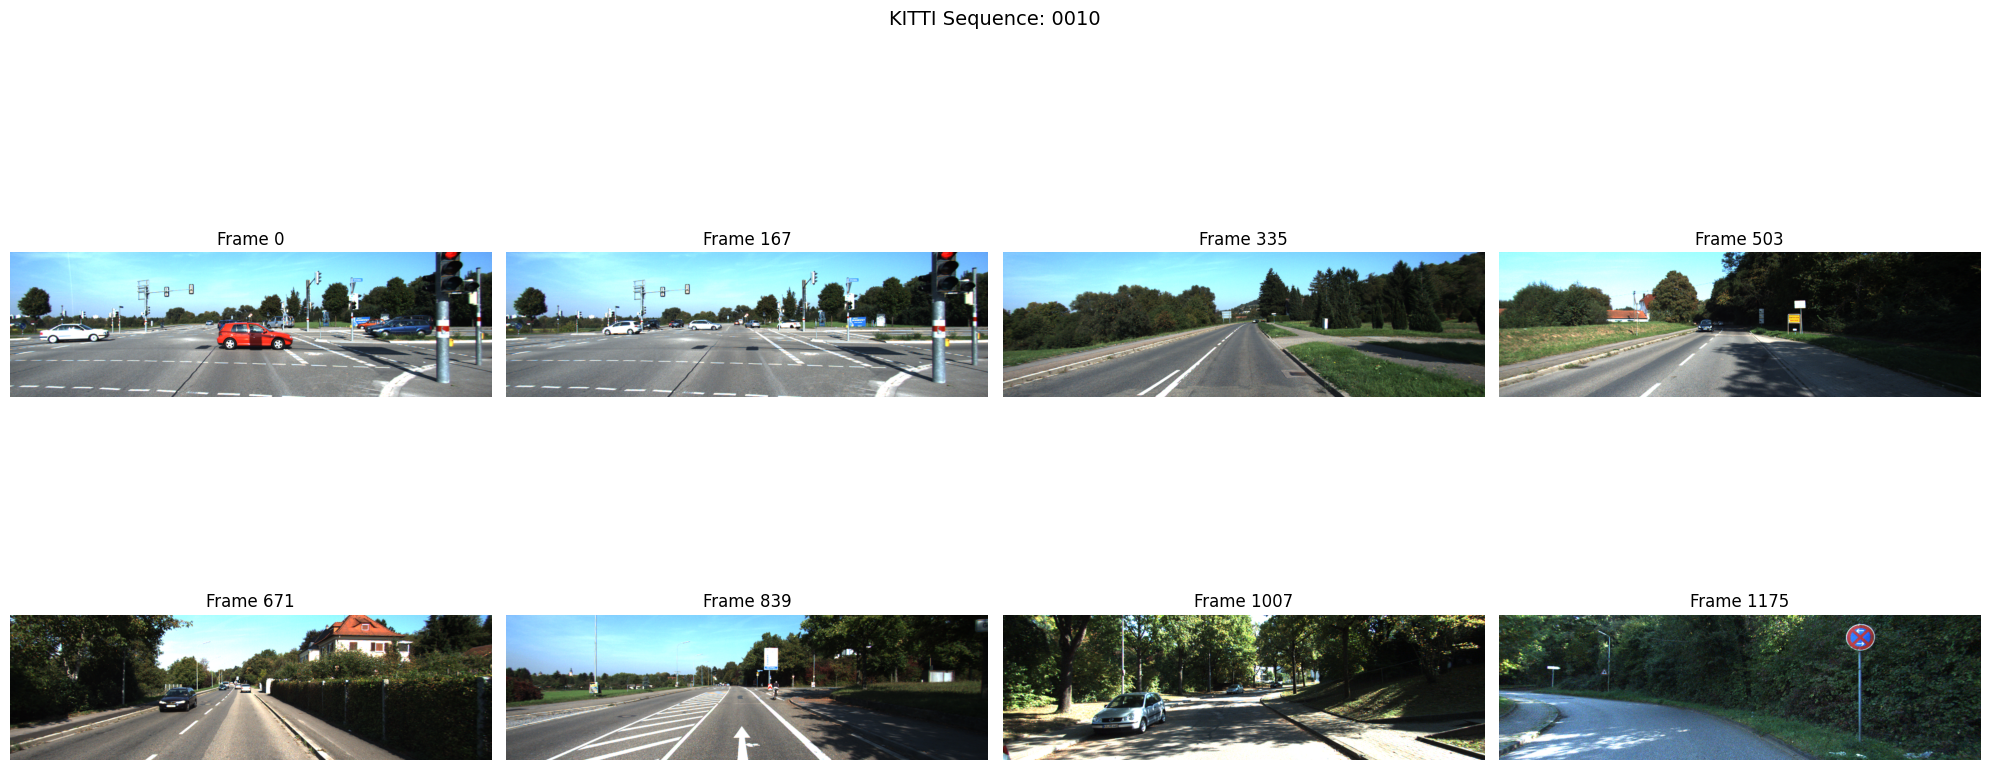

In [5]:
# Cell 5: 샘플 시퀀스 시각화

if len(seq_df) > 0:
    # 가장 긴 시퀀스 선택
    longest_seq = seq_df.loc[seq_df['num_images'].idxmax()]
    seq_path = Path(longest_seq['path'])
    
    print(f"샘플 시퀀스: {seq_path.name}")
    print(f"이미지 수: {longest_seq['num_images']}")
    
    # 이미지 로드
    images = sorted(list(seq_path.glob('*.png')) + list(seq_path.glob('*.jpg')))
    
    # 균등 간격으로 8장 선택
    indices = np.linspace(0, len(images)-1, 8, dtype=int)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for ax, idx in zip(axes, indices):
        img = cv2.imread(str(images[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"Frame {idx}")
        ax.axis('off')
    
    plt.suptitle(f"KITTI Sequence: {seq_path.name}", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("시각화할 시퀀스가 없습니다.")

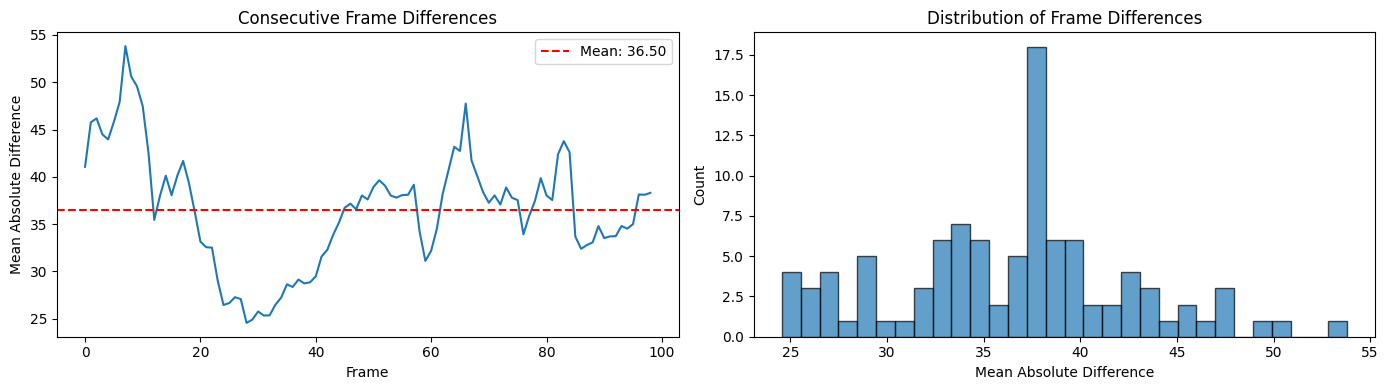


연속 프레임 차이 통계:
  평균: 36.50
  표준편차: 6.16
  최소: 24.56
  최대: 53.81


In [6]:
# Cell 6: 연속 프레임 분석 (Self-supervised 학습용)

def compute_frame_difference(img1, img2):
    """두 프레임 간 차이 계산"""
    # 그레이스케일 변환
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # 차이 계산
    diff = cv2.absdiff(gray1, gray2)
    mean_diff = np.mean(diff)
    
    return diff, mean_diff

if len(seq_df) > 0:
    # 샘플 시퀀스
    seq_path = Path(seq_df.iloc[0]['path'])
    images = sorted(list(seq_path.glob('*.png')) + list(seq_path.glob('*.jpg')))[:100]
    
    # 연속 프레임 차이 계산
    differences = []
    
    for i in range(len(images) - 1):
        img1 = cv2.imread(str(images[i]))
        img2 = cv2.imread(str(images[i + 1]))
        
        if img1 is not None and img2 is not None:
            _, mean_diff = compute_frame_difference(img1, img2)
            differences.append(mean_diff)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # 프레임 간 차이 그래프
    axes[0].plot(differences)
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('Mean Absolute Difference')
    axes[0].set_title('Consecutive Frame Differences')
    axes[0].axhline(np.mean(differences), color='red', linestyle='--', label=f'Mean: {np.mean(differences):.2f}')
    axes[0].legend()
    
    # 히스토그램
    axes[1].hist(differences, bins=30, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Mean Absolute Difference')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Frame Differences')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n연속 프레임 차이 통계:")
    print(f"  평균: {np.mean(differences):.2f}")
    print(f"  표준편차: {np.std(differences):.2f}")
    print(f"  최소: {np.min(differences):.2f}")
    print(f"  최대: {np.max(differences):.2f}")

In [7]:
# Cell 7: Self-supervised 학습용 데이터셋 클래스 정의

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class KITTISequenceDataset(Dataset):
    """
    KITTI 시퀀스 데이터셋 (Self-supervised 학습용)
    
    연속 프레임을 positive pair로 사용하는 contrastive learning에 적합
    
    참고: SimCLR (Chen et al., 2020) - 같은 이미지의 다른 augmentation을 positive pair로 사용
    여기서는 연속 프레임도 positive pair로 활용 가능
    """
    
    def __init__(self, sequence_dirs, transform=None, frame_gap=1):
        """
        Args:
            sequence_dirs: 시퀀스 디렉토리 리스트
            transform: 이미지 변환
            frame_gap: 연속 프레임 간격 (1=바로 다음 프레임)
        """
        self.transform = transform
        self.frame_gap = frame_gap
        self.samples = []
        
        # 모든 이미지 쌍 수집
        for seq_dir in sequence_dirs:
            seq_path = Path(seq_dir)
            images = sorted(list(seq_path.glob('*.png')) + list(seq_path.glob('*.jpg')))
            
            for i in range(len(images) - frame_gap):
                self.samples.append((str(images[i]), str(images[i + frame_gap])))
        
        print(f"데이터셋 생성: {len(self.samples):,}개 프레임 쌍")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img1_path, img2_path = self.samples[idx]
        
        # 이미지 로드
        img1 = cv2.imread(img1_path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        
        img2 = cv2.imread(img2_path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        
        # 변환 적용
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2

# SimCLR 스타일 증강
simclr_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ KITTISequenceDataset 클래스 정의 완료")

✅ KITTISequenceDataset 클래스 정의 완료


In [8]:
# Cell 8: Train/Val 분할

from sklearn.model_selection import train_test_split

if len(all_sequences) > 0:
    # 시퀀스 단위로 분할 (데이터 누수 방지)
    train_seqs, val_seqs = train_test_split(
        all_sequences, 
        test_size=0.2, 
        random_state=42
    )
    
    print(f"Train 시퀀스: {len(train_seqs)}개")
    print(f"Val 시퀀스: {len(val_seqs)}개")
    
    # 데이터셋 생성 (메모리 효율을 위해 작은 샘플로 테스트)
    # 실제 학습 시에는 전체 데이터 사용
    sample_train_seqs = train_seqs[:min(5, len(train_seqs))]
    
    train_dataset = KITTISequenceDataset(
        sequence_dirs=sample_train_seqs,
        transform=simclr_transform
    )
    
    # 데이터로더 테스트
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    
    # 샘플 배치 확인
    img1_batch, img2_batch = next(iter(train_loader))
    print(f"\n배치 shape: {img1_batch.shape}")
else:
    print("분할할 시퀀스가 없습니다.")

Train 시퀀스: 40개
Val 시퀀스: 10개
데이터셋 생성: 1,922개 프레임 쌍

배치 shape: torch.Size([4, 3, 224, 224])


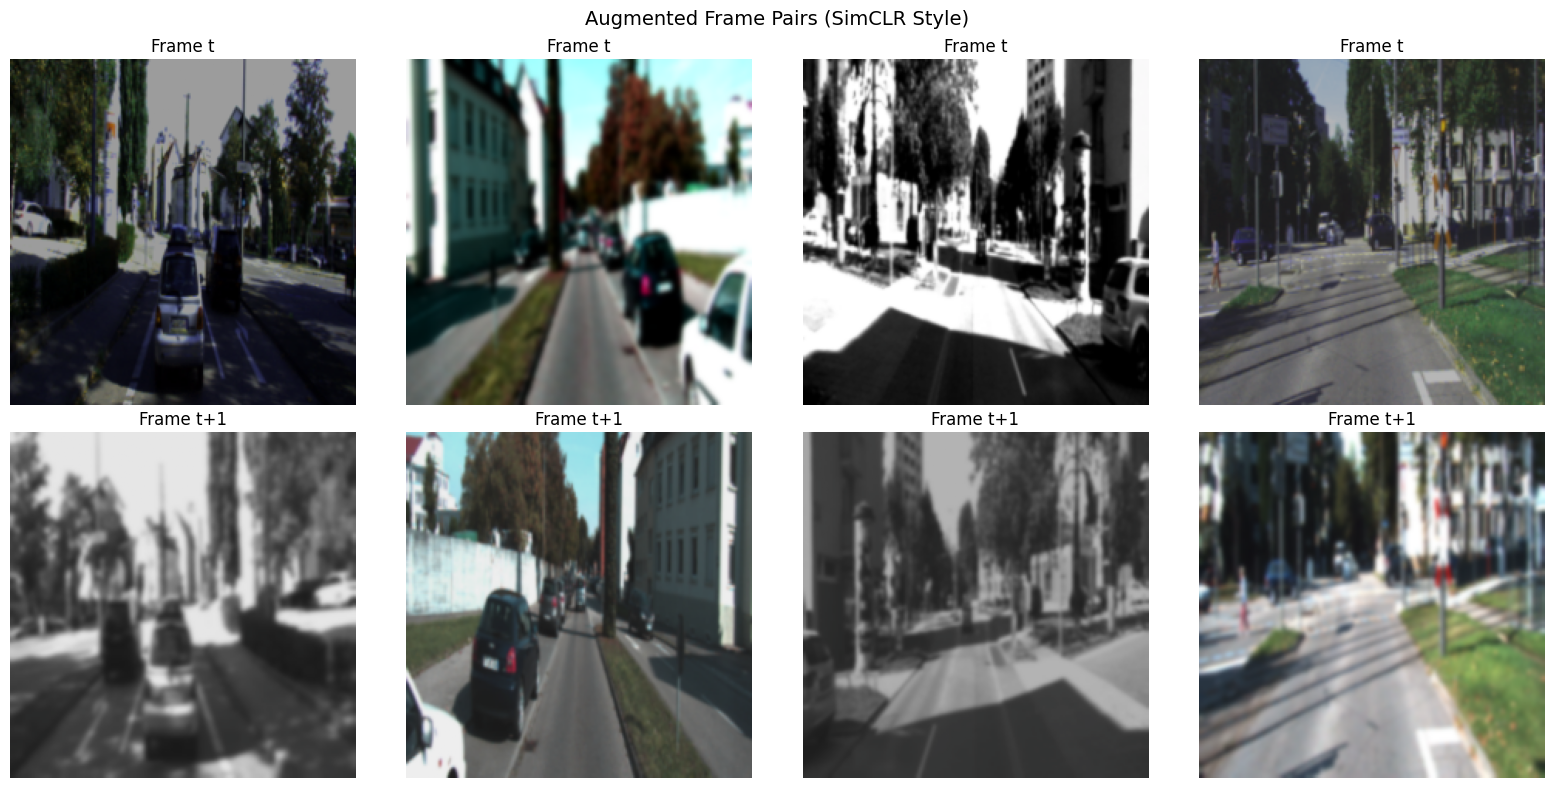

In [9]:
# Cell 9: 증강된 이미지 쌍 시각화

def denormalize(tensor):
    """ImageNet 정규화 역변환"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

if len(all_sequences) > 0 and 'train_dataset' in dir():
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(4):
        img1, img2 = train_dataset[i * 100]
        
        # 역정규화
        img1_vis = denormalize(img1).permute(1, 2, 0).numpy()
        img2_vis = denormalize(img2).permute(1, 2, 0).numpy()
        
        # 클리핑
        img1_vis = np.clip(img1_vis, 0, 1)
        img2_vis = np.clip(img2_vis, 0, 1)
        
        axes[0, i].imshow(img1_vis)
        axes[0, i].set_title(f"Frame t")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img2_vis)
        axes[1, i].set_title(f"Frame t+1")
        axes[1, i].axis('off')
    
    plt.suptitle("Augmented Frame Pairs (SimCLR Style)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [10]:
# Cell 10: 데이터셋 정보 저장

import json

# 데이터셋 정보 저장
kitti_dataset_info = {
    'total_sequences': len(all_sequences),
    'total_images': int(seq_df['num_images'].sum()) if len(seq_df) > 0 else 0,
    'train_sequences': len(train_seqs) if 'train_seqs' in dir() else 0,
    'val_sequences': len(val_seqs) if 'val_seqs' in dir() else 0,
    'sequence_paths': [str(s) for s in all_sequences],
    'train_paths': [str(s) for s in train_seqs] if 'train_seqs' in dir() else [],
    'val_paths': [str(s) for s in val_seqs] if 'val_seqs' in dir() else []
}

# 저장
save_path = DATASET_ROOT / 'kitti_dataset_info.json'
with open(save_path, 'w') as f:
    json.dump(kitti_dataset_info, f, indent=2)

print(f"데이터셋 정보 저장: {save_path}")
print(f"\n=" * 50)
print("KITTI 데이터 탐색 완료")
print("=" * 50)
print(f"총 시퀀스: {kitti_dataset_info['total_sequences']}")
print(f"총 이미지: {kitti_dataset_info['total_images']:,}")
print(f"\n다음 단계: 04_ssl_pretraining.ipynb")

데이터셋 정보 저장: c:\git\automotive\dataset\kitti_dataset_info.json

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
KITTI 데이터 탐색 완료
총 시퀀스: 50
총 이미지: 19,103

다음 단계: 04_ssl_pretraining.ipynb


## KITTI 데이터셋 요약

### 데이터 구조
- 연속 프레임 이미지 시퀀스
- 자율주행 시나리오 (도로, 차량, 보행자 등)

### Self-supervised 학습 전략
1. **연속 프레임 활용**: 시간적으로 가까운 프레임은 의미적으로 유사
2. **Contrastive Learning**: 같은 시퀀스의 프레임은 positive pair
3. **Data Augmentation**: SimCLR 스타일 증강으로 다양성 확보

### 참고 논문

| 논문 | 핵심 아이디어 |
|------|---------------|
| KITTI (Geiger et al., 2012) | 자율주행 벤치마크, 스테레오 카메라, LiDAR, GPS 데이터 제공 |
| SimCLR (Chen et al., 2020) | Contrastive learning, 강력한 augmentation으로 라벨 없이 표현 학습 |
| MoCo (He et al., 2020) | Momentum encoder로 안정적인 contrastive learning |